In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer

/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from transformers import BertForTokenClassification, BertTokenizer,  BertForMaskedLM, Trainer, TrainingArguments
from datasets import load_dataset
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import os
from transformers import BertTokenizerFast
import evaluate
import pandas as pd
import random
from datasets import DatasetDict
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from datasets import load_dataset

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
dataset = load_dataset("jnlpba", trust_remote_code = True)

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 18546
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3856
    })
})

In [7]:
# Define a sampling function
def sample_dataset(data, ratio):
    sample_size = int(len(data) * ratio)
    return data.select(random.sample(range(len(data)), sample_size))

# Set the ratio
ratio = 0.05

# Sample each subset
train_sampled = sample_dataset(dataset['train'], ratio)
validation_sampled = sample_dataset(dataset['validation'], ratio)

# Check the sizes
print(f"Sampled train size: {len(train_sampled)}")
print(f"Sampled validation size: {len(validation_sampled)}")


dataset = DatasetDict({
    "train": train_sampled,
    "validation": validation_sampled
})


Sampled train size: 927
Sampled validation size: 192


In [8]:
dataset['train'][0]['tokens']

['Involvement',
 'of',
 'a',
 'second',
 'lymphoid-specific',
 'enhancer',
 'element',
 'in',
 'the',
 'regulation',
 'of',
 'immunoglobulin',
 'heavy-chain',
 'gene',
 'expression',
 '.']

In [9]:
dataset['train'][0]['ner_tags']

[0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0]

In [10]:
dataset['train'][0]['id']

'17293'

In [11]:
label_list = dataset["train"].features[f"ner_tags"].feature.names
num_labels = len(label_list)
label_list



['O',
 'B-DNA',
 'I-DNA',
 'B-RNA',
 'I-RNA',
 'B-cell_line',
 'I-cell_line',
 'B-cell_type',
 'I-cell_type',
 'B-protein',
 'I-protein']

In [12]:
sample_data = dataset["train"].select(range(10)) 

df = pd.DataFrame({
    "tokens": [" ".join(example["tokens"]) for example in sample_data],
    "ner_tags": [example["ner_tags"] for example in sample_data]
})

df

,tokens,ner_tags
0,Involvement of a second lymphoid-specific enha...,"[0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0]"
1,We present evidence that induction of neutroph...,"[0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Multiple p21ras effector pathways regulate nuc...,"[0, 9, 0, 0, 0, 0, 0, 0, 7, 8, 8, 0]"
3,All-trans-retinoic acid ( ATRA ) is the drug o...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Expression of DNA in reticulocyte lysates or i...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,"Notably , the lack of pRB in these U937-derive...","[0, 0, 0, 0, 0, 9, 0, 0, 5, 6, 0, 0, 5, 6, 0, ..."
6,"We also demonstrate that the IKK complex , but...","[0, 0, 0, 0, 0, 9, 10, 0, 0, 0, 9, 10, 10, 10,..."
7,This paper provides a brief review of immune p...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8,T cells are considered to be unresponsive to t...,"[7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, ..."
9,The finding that dexamethasone has no effect o...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, ..."


B- indicates the beginning of an entity.
I- indicates a token is contained inside the same entity (for example, the State token is a part of an entity like Empire State Building).
0 indicates the token doesn’t correspond to any entity.

In [13]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

In [14]:

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding='max_length',
        max_length=128
    )
    labels = []
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs





In [15]:

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map: 100%|██████████| 192/192 [00:00<00:00, 10189.75 examples/s]


In [16]:
tokenized_datasets['train']

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 927
})

In [17]:
tokenized_datasets['train'][0]

{'id': '17293',
 'tokens': ['Involvement',
  'of',
  'a',
  'second',
  'lymphoid-specific',
  'enhancer',
  'element',
  'in',
  'the',
  'regulation',
  'of',
  'immunoglobulin',
  'heavy-chain',
  'gene',
  'expression',
  '.'],
 'ner_tags': [0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0],
 'input_ids': [101,
  1130,
  6005,
  23534,
  1880,
  1104,
  170,
  1248,
  181,
  25698,
  7874,
  118,
  2747,
  11778,
  1197,
  5290,
  1107,
  1103,
  8585,
  1104,
  13280,
  13601,
  2728,
  1403,
  2858,
  27515,
  1394,
  2302,
  118,
  4129,
  5565,
  2838,
  119,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [18]:

model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=num_labels)


metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Usunięcie indeksów ignorowanych (specjalne tokeny)
    true_predictions = [
        [p for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [l for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Spłaszczanie list
    true_predictions_flat = [int(item) for sublist in true_predictions for item in sublist]
    true_labels_flat = [int(item) for sublist in true_labels for item in sublist]

    # Zbieranie błędnych przykładów
    incorrect_examples = []
    for idx, (pred, label) in enumerate(zip(true_predictions, true_labels)):
        if pred != label:
            tokens = tokenized_datasets["validation"]["tokens"][idx]  # Oryginalne tokeny dla przykładu
            incorrect_examples.append({
                "tokens": tokens,
                "true_labels": label,
                "predicted_labels": pred
            })

    # Zapis błędnych przykładów do CSV
    if incorrect_examples:
        df_incorrect = pd.DataFrame(incorrect_examples)
        df_incorrect.to_csv("incorrect_predictions_trained.csv", index=False)

    # Obliczanie dokładności i F1
    accuracy = metric.compute(predictions=true_predictions_flat, references=true_labels_flat)
    f1 = f1_metric.compute(predictions=true_predictions_flat, references=true_labels_flat, average="weighted")["f1"]

    # Obliczenie macierzy pomyłek
    labels_list = list(set(true_labels_flat))  # Lista unikalnych etykiet NER
    cm = confusion_matrix(true_labels_flat, true_predictions_flat, labels=labels_list)
    
    # Wyświetlenie macierzy pomyłek
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_list)
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    disp.ax_.set_title("Confusion Matrix for NER Labels")
    
    return {"accuracy": accuracy, "f1": f1}





Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=256, lora_alpha=32, lora_dropout=0.1
)

In [20]:
model = get_peft_model(model, peft_config)

In [21]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=30,
    weight_decay=0.1,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_7493/3865790452.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


100%|██████████| 24/24 [00:01<00:00, 14.48it/s]


{'eval_loss': 2.5814762115478516,
 'eval_model_preparation_time': 0.0027,
 'eval_accuracy': {'accuracy': 0.013020319589662656},
 'eval_f1': 0.013894262524183593,
 'eval_runtime': 2.017,
 'eval_samples_per_second': 95.19,
 'eval_steps_per_second': 11.899}

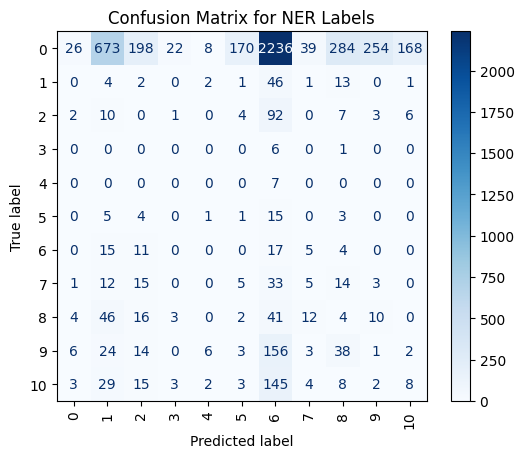

In [22]:
# Evaluate the model
trainer.evaluate()

                                                  
  3%|▎         | 118/3480 [00:14<20:42,  2.71it/s]

{'eval_loss': 2.502185821533203, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.01933320181495364}, 'eval_f1': 0.02601395158848831, 'eval_runtime': 1.5368, 'eval_samples_per_second': 124.933, 'eval_steps_per_second': 15.617, 'epoch': 1.0}


                                                  
  7%|▋         | 233/3480 [00:27<24:57,  2.17it/s]

{'eval_loss': 2.4137685298919678, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.04853028210692444}, 'eval_f1': 0.07987026138918911, 'eval_runtime': 1.547, 'eval_samples_per_second': 124.112, 'eval_steps_per_second': 15.514, 'epoch': 2.0}


                                                  
 10%|█         | 349/3480 [00:41<23:58,  2.18it/s]

{'eval_loss': 2.313246726989746, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.12112842769777077}, 'eval_f1': 0.19704928593503143, 'eval_runtime': 1.5418, 'eval_samples_per_second': 124.527, 'eval_steps_per_second': 15.566, 'epoch': 3.0}


                                                  
 13%|█▎        | 466/3480 [00:55<18:34,  2.70it/s]

{'eval_loss': 2.1982109546661377, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.25271256658117974}, 'eval_f1': 0.35975702121006964, 'eval_runtime': 1.5437, 'eval_samples_per_second': 124.379, 'eval_steps_per_second': 15.547, 'epoch': 4.0}


 14%|█▍        | 500/3480 [00:59<05:19,  9.34it/s]

{'loss': 2.408, 'grad_norm': 7.6511664390563965, 'learning_rate': 1.7126436781609195e-06, 'epoch': 4.31}


                                                  
 17%|█▋        | 581/3480 [01:09<22:13,  2.17it/s]

{'eval_loss': 2.0648837089538574, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.4383507595186427}, 'eval_f1': 0.5234948671768901, 'eval_runtime': 1.5387, 'eval_samples_per_second': 124.783, 'eval_steps_per_second': 15.598, 'epoch': 5.0}


                                                  
 20%|██        | 698/3480 [01:23<17:18,  2.68it/s]

{'eval_loss': 1.9090771675109863, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.6308936673900177}, 'eval_f1': 0.6412448842680906, 'eval_runtime': 1.5573, 'eval_samples_per_second': 123.291, 'eval_steps_per_second': 15.411, 'epoch': 6.0}


                                                  
 23%|██▎       | 813/3480 [01:37<20:31,  2.17it/s]

{'eval_loss': 1.7274366617202759, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.7378181100808838}, 'eval_f1': 0.6906780126750631, 'eval_runtime': 1.5475, 'eval_samples_per_second': 124.071, 'eval_steps_per_second': 15.509, 'epoch': 7.0}


                                                  
 27%|██▋       | 930/3480 [01:51<15:39,  2.71it/s]

{'eval_loss': 1.5222963094711304, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.7808246202406787}, 'eval_f1': 0.7086089847460433, 'eval_runtime': 1.5297, 'eval_samples_per_second': 125.518, 'eval_steps_per_second': 15.69, 'epoch': 8.0}


 29%|██▊       | 1000/3480 [01:58<04:17,  9.62it/s]

{'loss': 1.8573, 'grad_norm': 5.222342491149902, 'learning_rate': 1.425287356321839e-06, 'epoch': 8.62}


                                                   
 30%|███       | 1045/3480 [02:05<19:34,  2.07it/s]

{'eval_loss': 1.311914086341858, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.7966068258039061}, 'eval_f1': 0.7138913604281572, 'eval_runtime': 1.646, 'eval_samples_per_second': 116.645, 'eval_steps_per_second': 14.581, 'epoch': 9.0}


                                                   
 33%|███▎      | 1161/3480 [02:19<16:55,  2.28it/s]

{'eval_loss': 1.135941982269287, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8019333201814953}, 'eval_f1': 0.7160683336326118, 'eval_runtime': 1.4907, 'eval_samples_per_second': 128.795, 'eval_steps_per_second': 16.099, 'epoch': 10.0}


                                                   
 37%|███▋      | 1277/3480 [02:33<16:15,  2.26it/s]

{'eval_loss': 1.0281249284744263, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8035115407378182}, 'eval_f1': 0.7168497184705365, 'eval_runtime': 1.5041, 'eval_samples_per_second': 127.653, 'eval_steps_per_second': 15.957, 'epoch': 11.0}


                                                   
 40%|████      | 1393/3480 [02:47<15:41,  2.22it/s]

{'eval_loss': 0.9729108810424805, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.5077, 'eval_samples_per_second': 127.347, 'eval_steps_per_second': 15.918, 'epoch': 12.0}


 43%|████▎     | 1500/3480 [02:58<03:31,  9.35it/s]

{'loss': 1.1731, 'grad_norm': 1.5314216613769531, 'learning_rate': 1.1379310344827587e-06, 'epoch': 12.93}


                                                   
 43%|████▎     | 1509/3480 [03:01<15:08,  2.17it/s]

{'eval_loss': 0.9398012161254883, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.502, 'eval_samples_per_second': 127.827, 'eval_steps_per_second': 15.978, 'epoch': 13.0}


                                                   
 47%|████▋     | 1625/3480 [03:15<13:57,  2.22it/s]

{'eval_loss': 0.9152787327766418, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.5082, 'eval_samples_per_second': 127.302, 'eval_steps_per_second': 15.913, 'epoch': 14.0}


                                                   
 50%|█████     | 1742/3480 [03:29<10:20,  2.80it/s]

{'eval_loss': 0.8947611451148987, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.4755, 'eval_samples_per_second': 130.127, 'eval_steps_per_second': 16.266, 'epoch': 15.0}


                                                   
 53%|█████▎    | 1858/3480 [03:43<09:37,  2.81it/s]

{'eval_loss': 0.8774232864379883, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.474, 'eval_samples_per_second': 130.261, 'eval_steps_per_second': 16.283, 'epoch': 16.0}


                                                   
 57%|█████▋    | 1973/3480 [03:56<11:28,  2.19it/s]

{'eval_loss': 0.8622681498527527, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.5231, 'eval_samples_per_second': 126.058, 'eval_steps_per_second': 15.757, 'epoch': 17.0}


 57%|█████▋    | 2000/3480 [03:59<02:37,  9.38it/s]

{'loss': 0.9901, 'grad_norm': 2.0439414978027344, 'learning_rate': 8.50574712643678e-07, 'epoch': 17.24}


                                                   
 60%|██████    | 2090/3480 [04:11<08:21,  2.77it/s]

{'eval_loss': 0.8492133021354675, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.4904, 'eval_samples_per_second': 128.822, 'eval_steps_per_second': 16.103, 'epoch': 18.0}


                                                   
 63%|██████▎   | 2206/3480 [04:25<07:59,  2.65it/s]

{'eval_loss': 0.8375811576843262, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.6118, 'eval_samples_per_second': 119.125, 'eval_steps_per_second': 14.891, 'epoch': 19.0}


                                                   
 67%|██████▋   | 2321/3480 [04:38<08:44,  2.21it/s]

{'eval_loss': 0.8274543881416321, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.5032, 'eval_samples_per_second': 127.729, 'eval_steps_per_second': 15.966, 'epoch': 20.0}


 70%|██████▉   | 2435/3480 [04:51<01:51,  9.35it/s]/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
                                                   
 70%|███████   | 2437/3480 [04:52<07:54,  2.20it/s]

{'eval_loss': 0.8189659714698792, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.5219, 'eval_samples_per_second': 126.158, 'eval_steps_per_second': 15.77, 'epoch': 21.0}


 72%|███████▏  | 2500/3480 [04:59<01:45,  9.31it/s]

{'loss': 0.9128, 'grad_norm': 1.6834131479263306, 'learning_rate': 5.632183908045976e-07, 'epoch': 21.55}


                                                   
 73%|███████▎  | 2553/3480 [05:07<06:56,  2.23it/s]

{'eval_loss': 0.8115546703338623, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.4933, 'eval_samples_per_second': 128.571, 'eval_steps_per_second': 16.071, 'epoch': 22.0}


                                                   
 77%|███████▋  | 2669/3480 [05:21<07:44,  1.75it/s]

{'eval_loss': 0.8051379323005676, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.5484, 'eval_samples_per_second': 123.995, 'eval_steps_per_second': 15.499, 'epoch': 23.0}


                                                   
 80%|████████  | 2785/3480 [05:35<05:16,  2.20it/s]

{'eval_loss': 0.7998649477958679, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.5133, 'eval_samples_per_second': 126.877, 'eval_steps_per_second': 15.86, 'epoch': 24.0}


                                                   
 83%|████████▎ | 2901/3480 [05:49<04:23,  2.20it/s]

{'eval_loss': 0.7955905795097351, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.5193, 'eval_samples_per_second': 126.376, 'eval_steps_per_second': 15.797, 'epoch': 25.0}


 86%|████████▌ | 3000/3480 [05:59<00:51,  9.23it/s]

{'loss': 0.8832, 'grad_norm': 0.9870089888572693, 'learning_rate': 2.758620689655172e-07, 'epoch': 25.86}


                                                   
 87%|████████▋ | 3018/3480 [06:03<02:44,  2.81it/s]

{'eval_loss': 0.7921261787414551, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.4684, 'eval_samples_per_second': 130.755, 'eval_steps_per_second': 16.344, 'epoch': 26.0}


                                                   
 90%|█████████ | 3133/3480 [06:17<02:36,  2.22it/s]

{'eval_loss': 0.7894911766052246, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.5017, 'eval_samples_per_second': 127.851, 'eval_steps_per_second': 15.981, 'epoch': 27.0}


                                                   
 93%|█████████▎| 3249/3480 [06:31<01:46,  2.16it/s]

{'eval_loss': 0.7876488566398621, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.5529, 'eval_samples_per_second': 123.639, 'eval_steps_per_second': 15.455, 'epoch': 28.0}


                                                   
 97%|█████████▋| 3365/3480 [06:45<00:51,  2.23it/s]

{'eval_loss': 0.786552906036377, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.4919, 'eval_samples_per_second': 128.697, 'eval_steps_per_second': 16.087, 'epoch': 29.0}


                                                   
100%|██████████| 3480/3480 [06:59<00:00,  8.30it/s]


{'eval_loss': 0.7861900329589844, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': {'accuracy': 0.8041033734464391}, 'eval_f1': 0.7171423853285027, 'eval_runtime': 1.4455, 'eval_samples_per_second': 132.829, 'eval_steps_per_second': 16.604, 'epoch': 30.0}
{'train_runtime': 419.5032, 'train_samples_per_second': 66.293, 'train_steps_per_second': 8.296, 'train_loss': 1.3016564730940194, 'epoch': 30.0}


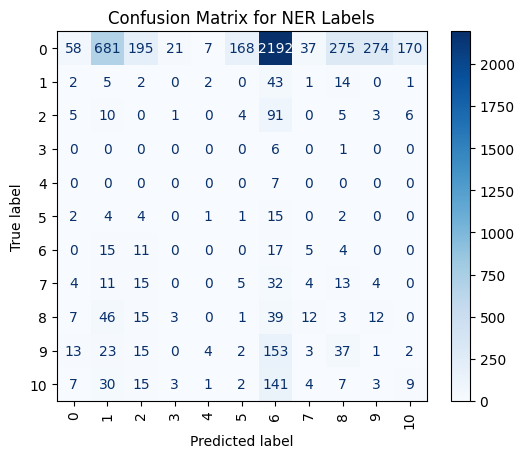

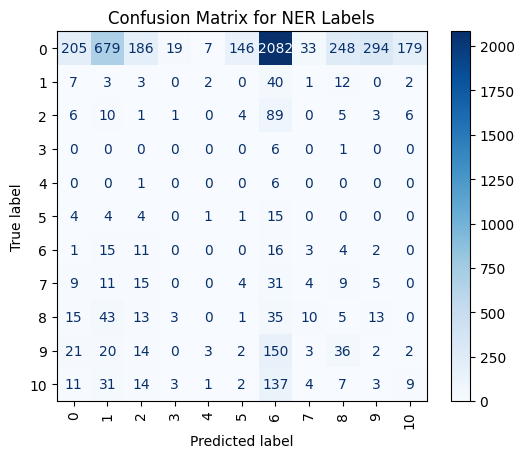

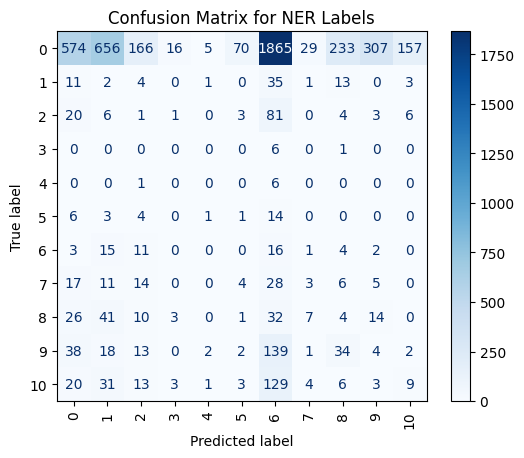

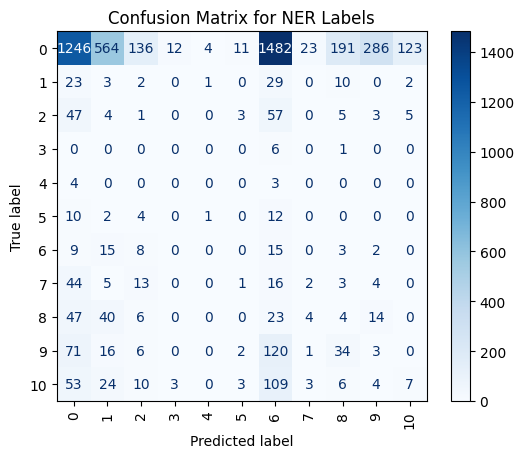

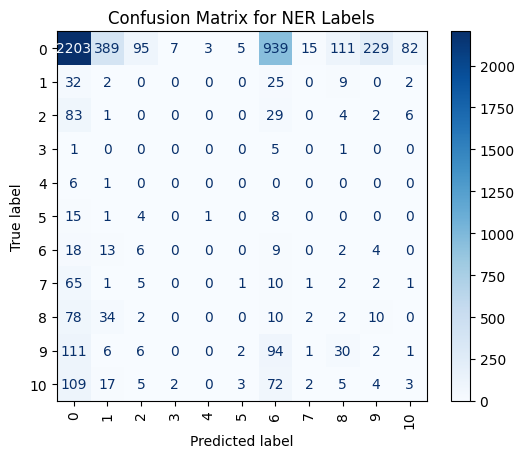

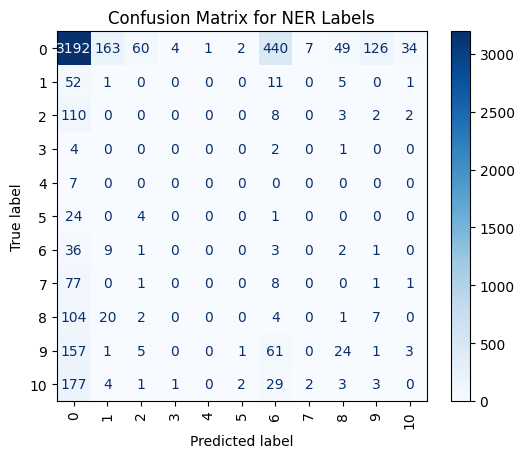

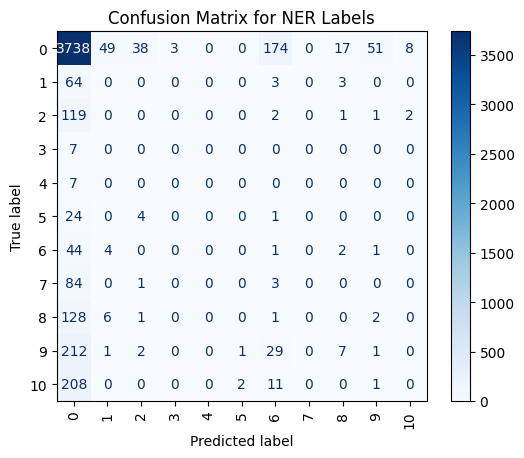

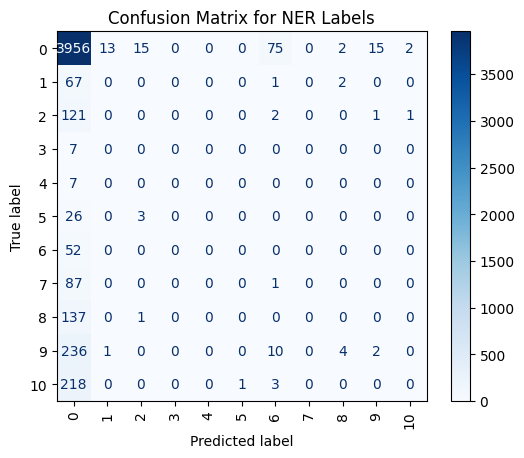

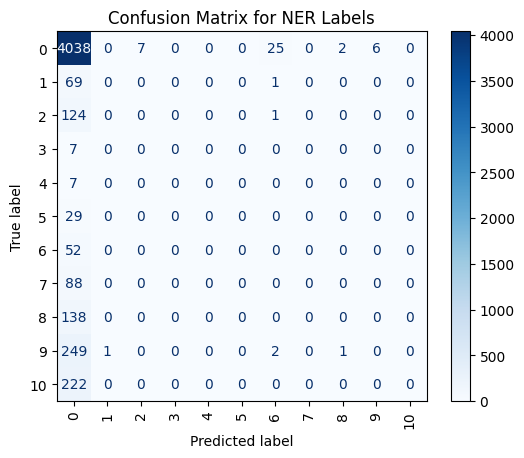

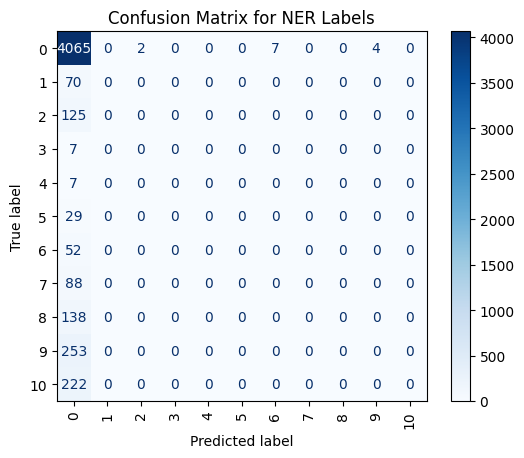

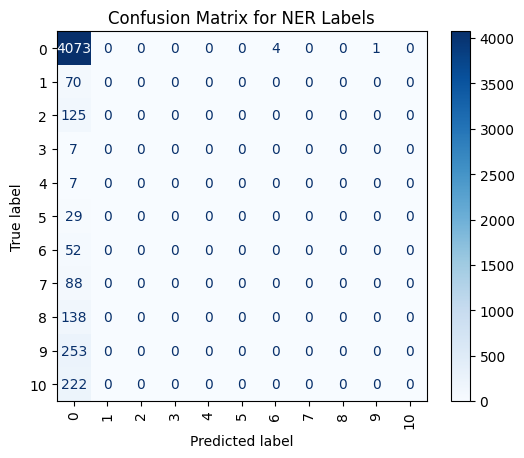

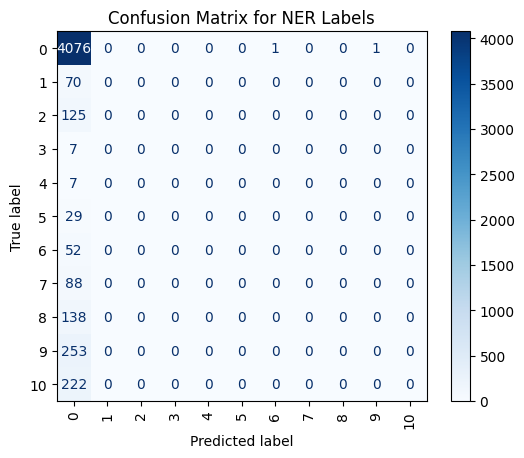

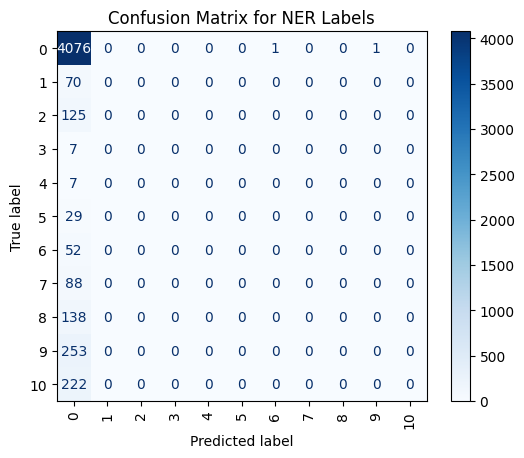

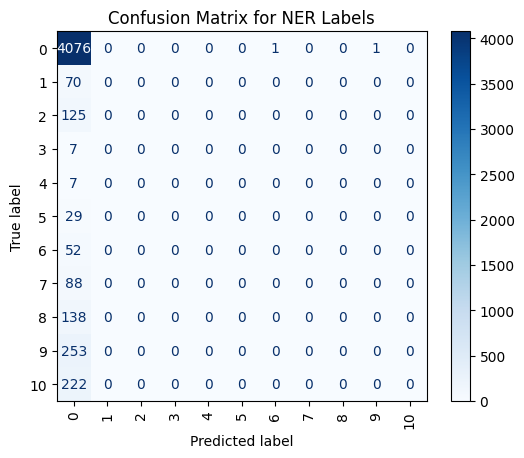

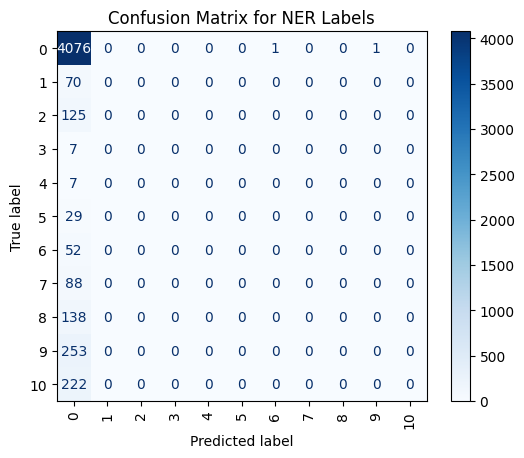

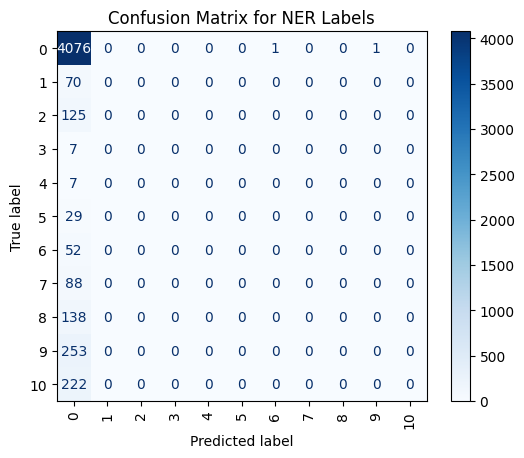

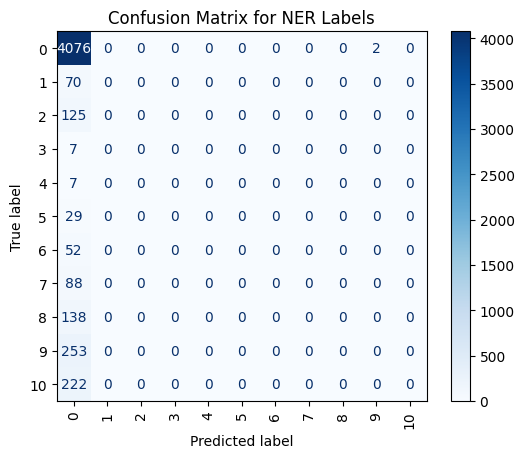

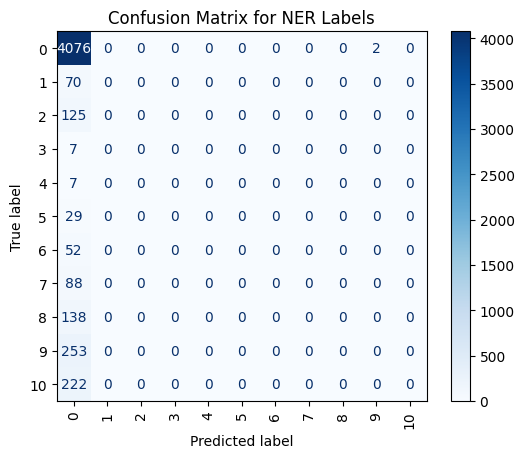

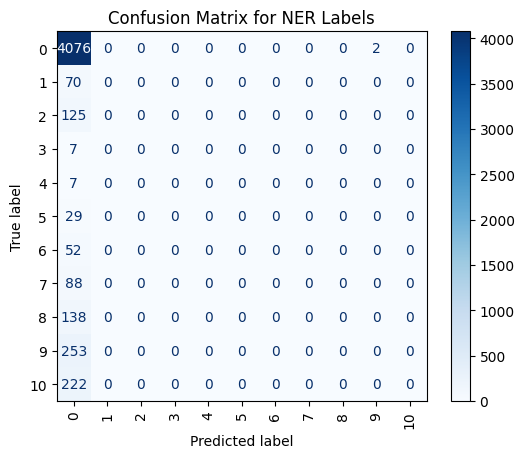

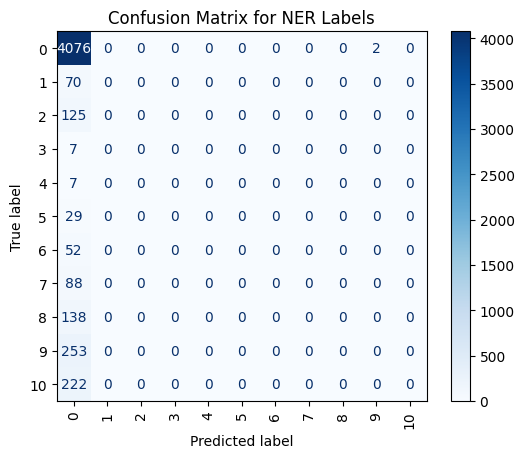

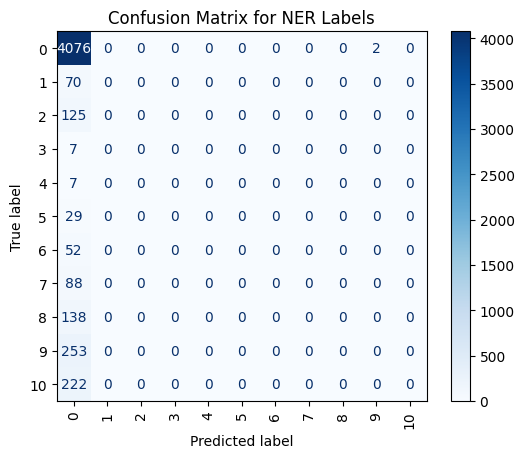

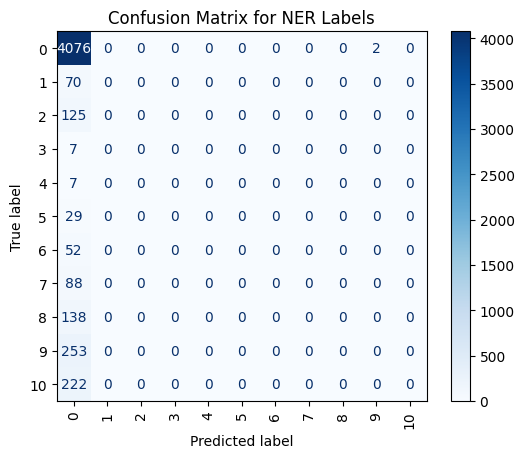

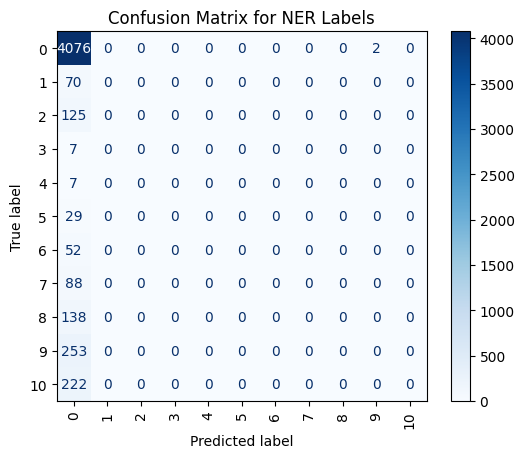

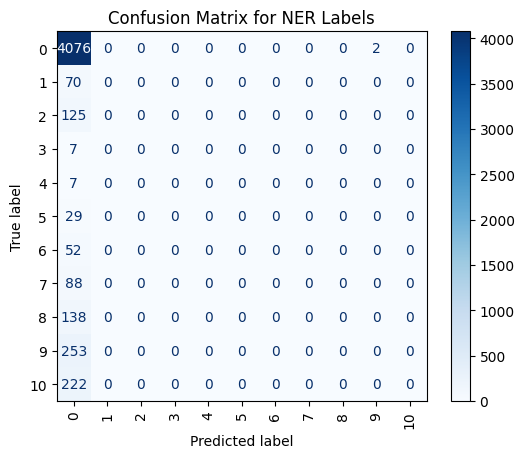

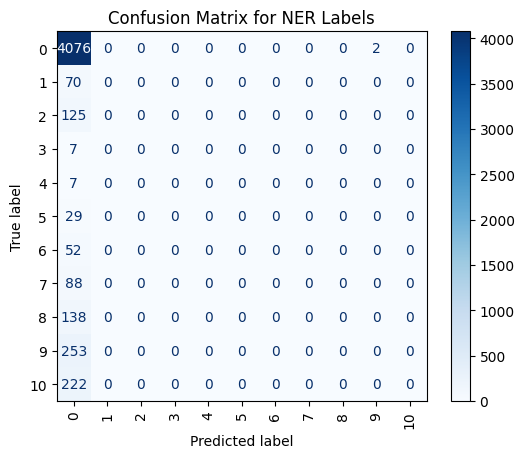

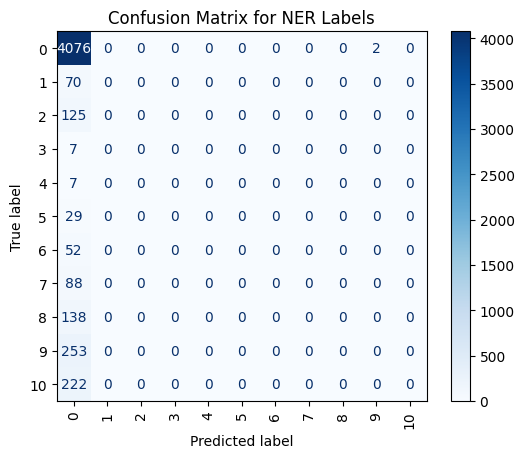

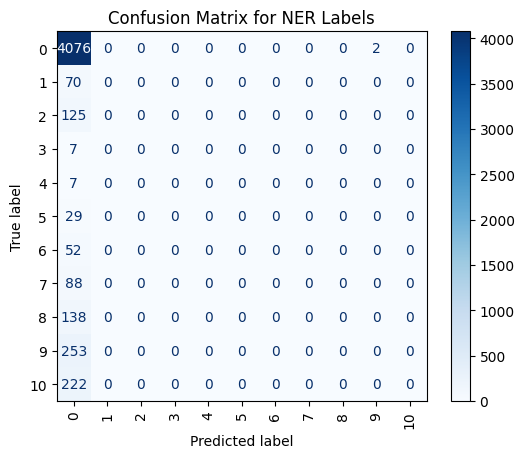

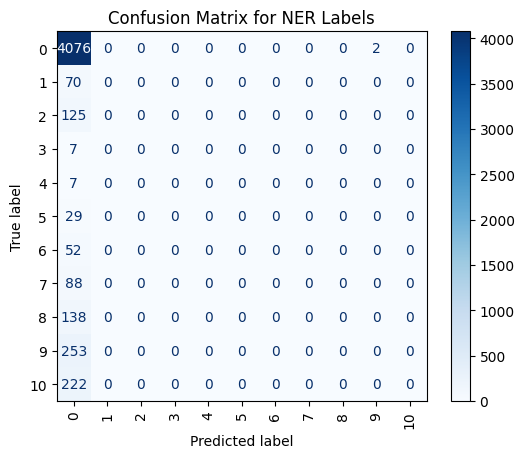

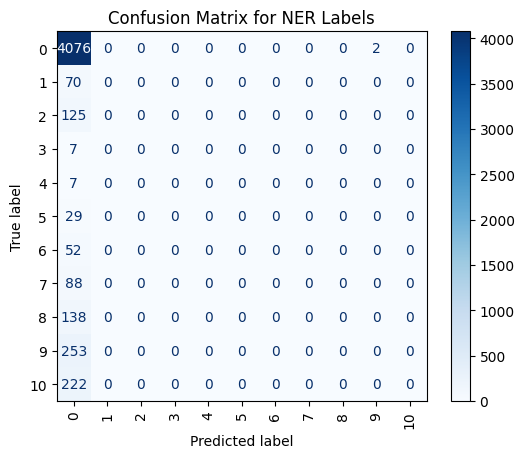

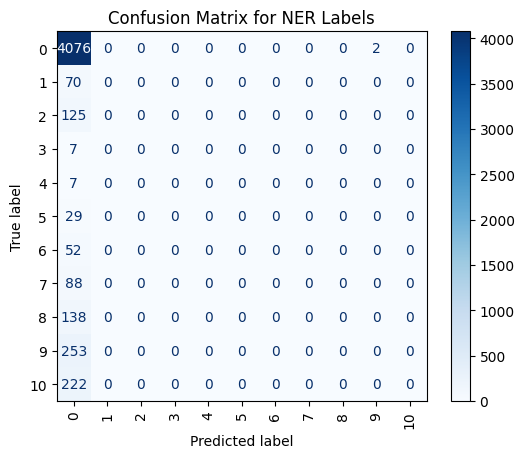

In [23]:
trainer.train()
trainer.save_model("./saved_model_bert_lora_for_token4")

100%|██████████| 24/24 [00:01<00:00, 16.86it/s]


{'eval_loss': 0.7861900329589844,
 'eval_model_preparation_time': 0.0027,
 'eval_accuracy': {'accuracy': 0.8041033734464391},
 'eval_f1': 0.7171423853285027,
 'eval_runtime': 1.4675,
 'eval_samples_per_second': 130.834,
 'eval_steps_per_second': 16.354,
 'epoch': 30.0}

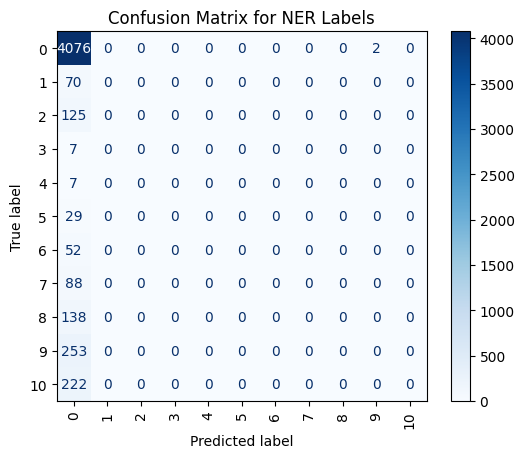

In [24]:
trainer.evaluate()

# Wizualizacje na wytrenowanym modelu

In [25]:
from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer
import torch

# Ścieżka do zapisanych wag modelu
model_path = "./saved_model_bert_lora_for_token"

# Wczytanie konfiguracji z odpowiednią liczbą etykiet
config = AutoConfig.from_pretrained(model_path)
config.num_labels = num_labels# Upewnij się, że jest to liczba etykiet, której używałeś podczas trenowania

# Wczytanie modelu i tokenizera
model = AutoModelForTokenClassification.from_pretrained(model_path, config=config, ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Przekazanie modelu na GPU, jeśli jest dostępne
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized because the shapes did not match:
- bert.embeddings.word_embeddings.weight: found shape torch.Size([28996, 768]) in the checkpoint and torch.Size([30522, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=

In [26]:
import torch
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
import numpy as np



test_dataset = tokenized_datasets["validation"].select(range(15))
print(test_dataset[0])


def get_embeddings(dataset, model, tokenizer):
    model.eval()
    embeddings = []
    labels = []
    tokens = []
    
    with torch.no_grad():
        for example in dataset:
            inputs = tokenizer(
                example["tokens"],is_split_into_words=True,return_tensors="pt", truncation=True, padding='max_length', max_length=128
            ).to(device)
            outputs = model(**inputs, output_hidden_states=True)
       
            token_embeddings = outputs.hidden_states[-1].squeeze(0) 
            embeddings.append(token_embeddings.cpu().numpy())
            labels.extend(example["ner_tags"])
            tokens.extend(example["tokens"])


    flat_embeddings = np.vstack([embedding[:len(label)] for embedding, label in zip(embeddings, dataset["ner_tags"])])
    flat_labels = [label for sublist in dataset["ner_tags"] for label in sublist]
    flat_tokens = [token for sublist in dataset["tokens"] for token in sublist]
    
    return flat_embeddings, flat_labels, flat_tokens

embeddings, labels, tokens = get_embeddings(test_dataset, model, tokenizer)


reducer = TSNE(n_components=2, random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)


df = pd.DataFrame({
    "x": reduced_embeddings[:, 0],
    "y": reduced_embeddings[:, 1],
    "label": labels,
    "token": tokens
})

fig = px.scatter(
    df, x="x", y="y", color="label", hover_data=["token"],
    title="2D Vector Space of Test Examples",
    labels={"color": "NER Label"}
)
fig.show()


{'id': '3100', 'tokens': ['Only', 'PPAR-gamma', 'agonists', '(', 'thiazolidinediones', ')', ',', 'and', 'not', 'PPAR-alpha', 'agonists', ',', 'mimicked', 'the', 'effect', 'of', '15d-PGJ', '(', '2', ')', 'on', 'B-lineage', 'cells', ',', 'indicating', 'that', 'the', 'mechanism', 'by', 'which', '15d-PGJ', '(', '2', ')', 'negatively', 'affects', 'B-lineage', 'cells', 'involves', 'in', 'part', 'PPAR-gamma', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 9, 0], 'input_ids': [101, 2809, 27660, 12426, 118, 21400, 2403, 22158, 1116, 113, 24438, 1465, 6112, 17299, 9044, 23997, 1116, 114, 117, 1105, 1136, 27660, 12426, 118, 11164, 2403, 22158, 1116, 117, 27180, 7831, 1103, 2629, 1104, 1405, 1181, 118, 153, 2349, 4538, 113, 123, 114, 1113, 139, 118, 14209, 3652, 117, 7713, 1115, 1103, 6978, 1118, 1134, 1405, 1181, 118, 153, 2349, 4538, 113, 123, 114, 21598, 13974, 139, 118, 14209, 3652, 6808, 1107, 1226,

In [27]:
# Dodajmy identyfikatory przykładów do DataFrame
example_ids = []
for idx, example in enumerate(test_dataset):
    example_ids.extend([idx] * len(example["tokens"]))

# Aktualizujemy DataFrame o identyfikatory przykładów
df["example_id"] = example_ids

# Tworzymy nowy wykres
fig2 = px.scatter(
    df, x="x", y="y", color="example_id", hover_data=["token"],
    title="2D Vector Space of Test Examples (Grouped by Example)",
    labels={"color": "Example ID"}
)
fig2.show()


# Wizauliacja poprawnych przykładów

In [28]:
import torch
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
import numpy as np
from datasets import load_dataset

test_dataset = dataset["validation"].select(range(100))  

# Funkcja do uzyskania embeddingów i przewidywań
def get_predictions_and_embeddings(dataset, model, tokenizer):
    model.eval()
    embeddings = []
    true_labels = []
    pred_labels = []
    tokens = []
    correct_examples = []

    with torch.no_grad():
        for example in dataset:
            inputs = tokenizer(
                example["tokens"], is_split_into_words=True, return_tensors="pt",
                truncation=True, padding='max_length', max_length=128
            ).to(device)
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()

            # Pobieramy embeddingi
            token_embeddings = outputs.hidden_states[-1].squeeze(0).cpu().numpy()
            true_label = example["ner_tags"]
            tokens.extend(example["tokens"])

            # Dopasowujemy długość predykcji do prawdziwych etykiet
            predictions = predictions[:len(true_label)]

            if list(predictions) == true_label:
                embeddings.append(token_embeddings[:len(true_label)])
                true_labels.extend(true_label)
                pred_labels.extend(predictions)
                correct_examples.extend(example["tokens"])

    # Spłaszczamy embeddingi
    flat_embeddings = np.vstack([emb for emb in embeddings])
    flat_labels = true_labels
    flat_tokens = [token for sublist in correct_examples for token in sublist]

    return flat_embeddings, flat_labels, flat_tokens

# Pobieramy embeddingi i poprawnie sklasyfikowane przykłady
embeddings, labels, tokens = get_predictions_and_embeddings(test_dataset, model, tokenizer)

# Sprawdzamy najmniejszą długość
min_length = min(len(reduced_embeddings), len(labels), len(tokens))

# Przycinamy listy do tej długości
reduced_embeddings = reduced_embeddings[:min_length]
labels = labels[:min_length]
tokens = tokens[:min_length]

# Tworzymy DataFrame do wizualizacji
df = pd.DataFrame({
    "x": reduced_embeddings[:, 0],
    "y": reduced_embeddings[:, 1],
    "label": labels,
    "token": tokens
})

# Wizualizacja za pomocą Plotly
fig = px.scatter(
    df, x="x", y="y", color="label", hover_data=["token"],
    title="2D Vector Space of Correctly Classified Examples",
    labels={"color": "NER Label"}
)
fig.show()


In [29]:
import torch
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
import numpy as np



test_dataset = tokenized_datasets["train"]
print(test_dataset[0])

def get_embeddings(dataset, model, tokenizer):
    model.eval()
    embeddings = []
    labels = []
    tokens = []
    
    with torch.no_grad():
        for example in dataset:
            inputs = tokenizer(
                example["tokens"], is_split_into_words=True, return_tensors="pt",
                truncation=True, padding='max_length', max_length=128
            ).to(device)
            
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).squeeze().cpu()

            token_embeddings = outputs.hidden_states[-1].squeeze(0)
            true_label = example["ner_tags"]
            predictions = predictions[:len(true_label)]

            # Only append correctly classified examples
            if list(predictions) == true_label:
                embeddings.append(token_embeddings[:len(true_label)].cpu().numpy())
                labels.extend(true_label)
                tokens.extend(example["tokens"][:len(true_label)])

    # Flatten the embeddings and ensure lengths match
    flat_embeddings = np.vstack(embeddings)
    flat_labels = labels
    flat_tokens = tokens

    print(f"Lengths - embeddings: {len(flat_embeddings)}, labels: {len(flat_labels)}, tokens: {len(flat_tokens)}")

    return flat_embeddings, flat_labels, flat_tokens



embeddings, labels, tokens = get_embeddings(test_dataset, model, tokenizer)


reducer = TSNE(n_components=2, random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)


df = pd.DataFrame({
    "x": reduced_embeddings[:, 0],
    "y": reduced_embeddings[:, 1],
    "label": labels,
    "token": tokens
})

fig = px.scatter(
    df, x="x", y="y", color="label", hover_data=["token"],
    title="2D Vector Space of Test Examples",
    labels={"color": "NER Label"}
)
fig.show()


{'id': '17293', 'tokens': ['Involvement', 'of', 'a', 'second', 'lymphoid-specific', 'enhancer', 'element', 'in', 'the', 'regulation', 'of', 'immunoglobulin', 'heavy-chain', 'gene', 'expression', '.'], 'ner_tags': [0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0], 'input_ids': [101, 1130, 6005, 23534, 1880, 1104, 170, 1248, 181, 25698, 7874, 118, 2747, 11778, 1197, 5290, 1107, 1103, 8585, 1104, 13280, 13601, 2728, 1403, 2858, 27515, 1394, 2302, 118, 4129, 5565, 2838, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Poprawe z wyłączeniem 0

In [30]:
def get_embeddings(dataset, model, tokenizer):
    model.eval()
    embeddings = []
    labels = []
    tokens = []
    accuracy_threshold = 0.4 

    with torch.no_grad():
        for example in dataset:
            inputs = tokenizer(
                example["tokens"], is_split_into_words=True, return_tensors="pt",
                truncation=True, padding='max_length', max_length=128
            ).to(device)
            
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).squeeze().cpu()

            # Pobieramy embeddingi i prawdziwe etykiety
            token_embeddings = outputs.hidden_states[-1].squeeze(0)
            true_labels = example["ner_tags"]
            tokens_list = example["tokens"]

        
            predictions = predictions[:len(true_labels)]

            # Filtrowanie etykiet `0`
            non_zero_indices = [i for i, label in enumerate(true_labels) if label != 0]
            filtered_predictions = [predictions[i] for i in non_zero_indices]
            filtered_true_labels = [true_labels[i] for i in non_zero_indices]
            filtered_tokens = [tokens_list[i] for i in non_zero_indices]
            filtered_embeddings = token_embeddings[non_zero_indices].cpu().numpy()


            if len(filtered_true_labels) > 0: 
                correct_predictions = sum(
                    [1 for pred, true in zip(filtered_predictions, filtered_true_labels) if pred == true]
                )
                accuracy = correct_predictions / len(filtered_true_labels)

    
                if accuracy >= accuracy_threshold:
                    embeddings.append(filtered_embeddings)
                    labels.extend(filtered_true_labels)
                    tokens.extend(filtered_tokens)

    if(len(embeddings) > 0):
        print('S')
        # Spłaszczamy listy
        flat_embeddings = np.vstack(embeddings)
        flat_labels = labels
        flat_tokens = tokens

        print(f"Lengths - embeddings: {len(flat_embeddings)}, labels: {len(flat_labels)}, tokens: {len(flat_tokens)}")

        return flat_embeddings, flat_labels, flat_tokens
    else: 
        print('Empty!')
        return [], [], []

In [31]:
embeddings, labels, tokens = get_embeddings(test_dataset, model, tokenizer)
if(len(embeddings) > 0):
    reducer = TSNE(n_components=2, random_state=42)
    reduced_embeddings = reducer.fit_transform(embeddings)


    df = pd.DataFrame({
        "x": reduced_embeddings[:, 0],
        "y": reduced_embeddings[:, 1],
        "label": labels,
        "token": tokens
    })

    fig = px.scatter(
        df, x="x", y="y", color="label", hover_data=["token"],
        title="2D Vector Space of Test Examples",
        labels={"color": "NER Label"}
    )
    fig.show()

Empty!
